# Markov Chain Monte Carlo

<a href="https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo" target="_blank">Markov chain Monte Carlo (MCMC)</a> is a broad class of algorithms which sample from a probability distribution. In particular, MCMC methods have found various applications in physics, such as in the area statistical mechanics. In this post we will explore how to use MCMC to simulate the magnetic properties of a crystal.

## The 2D Ising Model

The <a href="https://en.wikipedia.org/wiki/Ising_model" target="_blank">2D Ising model</a> is a model of <a href="https://en.wikipedia.org/wiki/Ferromagnetism" target="_blank">ferromagnetism</a>, usually consisting of a lattice of spins. Each spin can either be in the spin up or the spin down states. Ferromagnetism occurs when the vast majority of the spins in the lattice point occupy the same state as shown in the figure below.

<img src="https://github.com/natsunoyuki/blog_posts/blob/main/images/Ising_model_1.jpg?raw=True" alt="drawing" width="500"/>

Individual ferromagnetic spins tend to want to point in the same direction as the neighbouring spins as this configuration lowers the energy of the crystal. When the vast majority of spins are pointing in the same direction, the lattice exhibits magnetization and becomes magnetic. However, heating the spins increases the amount of energy in the lattice, and will result in more spins flipping randomly, thereby decreasing the amount of magnetization until all spins in the lattice are flipping randomly. The lattice eventually becomes non-magnetic after being heated past a certain temperature called the <a href="https://en.wikipedia.org/wiki/Curie_temperature" target="_blank">Curie temperature</a>.

## The Metropolis-Hastings Algorithm

For the 2D Ising model, each individual spin tends to want to point in the same direction as the 4 nearest neighbouring spins upwards, rightwards, downwards and leftwards of that spin. More complex models might consider other configurations such as the next nearest neighbouring spins.

Each iteration, we randomly choose a spin `s0` in the lattice and compute the sum of the 4 nearest neighbouring spins' `[s1, s2, s3, s4]` values: 

`___s4___`   
`s3_s0_s1`   
`___s2___`.

The randomly chosen spin has 2 possible values: -1 and 1. The sum of the 4 nearest neighbouring spins have the following possible 5 values: -4, -2, 0, 2, 4.  This leads to a total of 10 different possible configurations for this set of 5 spins. Each configuration corresponds to a different level of energy of the system, and hence a different probability of the chosen spin flipping due to the effects of the 4 neighbouring spins. In the Metropolis-Hastings algorithm, we sample the uniform random distribution. If the sampled random number is smaller than the probability of flipping for a given configuration, the chosen spin flips. If not, nothing happens. This process is repeated until the entire lattice achieves equilibirum and no net changes occur due to random flipping.

We code this algorithm in `ising2D` below. `ising2D` takes 4 inputs: the size of the x-axis `Nx`, the size of the y-axis `Ny`, the array of spin states in the lattice `spin`, and an array of probability of spin flips `pflip`. The function performs 1 iteration of the MCMC simulation and returns the updated array of spins states.

In this Python code instead of using a 2D array to contain the 2D lattice of spins, we fold the 2D array into a 1D array in order to reduce computational cost. Given some randomly chosen spin on the folded 1D array, its corresponding 2D array grid points are `x = np.mod(r, Nx)` and `y = r // Nx`. The corresponding 4 nearest neighbouring spins have the folded 1D array grid points: 

* `np.mod(x + 1, Nx) + y * Ny` for the spin to the right `s1`,
* `x + np.mod(y + 1, Ny) * Nx` for the spin to the bottom `s2`,
* `np.mod(x - 1 + Nx, Nx) + y * Nx` for the spin to the left `s3`,
* `x + np.mod(y - 1 + Ny, Ny) * Nx` for the spin to the top `s4`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import tqdm

import warnings
warnings.filterwarnings("ignore")

np.random.seed(123) # seed the RNG.

def ising2D(Nx, Ny, spin, pflip):
    """
    Inputs:
        Nx: int
            Size of the x-axis.
        Ny: int
            Size of the y-axis.
        spin: array
            Array containing the lattice of spins.
        pflip: array
            Array containing the flip probabilities for a given temperature and lattice structure.
    Outputs:
        spin: array
            Array containing the updated lattice of spins.
    """
    N = Nx * Ny # Total number of spins in the lattice.
    
    # Randomly choose a spin in the lattice.
    r = int(np.random.random() * N)
    # Obtain the corresponding x and y grid points.
    x = np.mod(r, Nx)
    y = r // Nx
    
    # Location of the spins in the lattice.
    #     s4
    #  s3 s0 s1 
    #     s2
    s0 = spin[r]
    s1 = spin[np.mod(x + 1, Nx) + y * Ny]
    s2 = spin[x + np.mod(y + 1, Ny) * Nx]
    s3 = spin[np.mod(x - 1 + Nx, Nx) + y * Nx]
    s4 = spin[x + np.mod(y - 1 + Ny, Ny) * Nx]
    
    # Sum of the nearest neighbours' spin values.
    neighbours = s1 + s2 + s3 + s4

    # Obtain the corresponding probability of s0 flipping.
    # For this system of 5 spins, there are 2 different configurations
    # due to s0 being able to take on the values {-1, 1}
    if s0 == 1:
        pfliprow = 0
    elif s0 == -1:
        pfliprow = 1
    # And there are 5 different configurations due to neighbours being able
    # to take on the values {-4, -2, 0, 2, 4}.
    if neighbours == -4:
        pflipcol = 0
    elif neighbours == -2:
        pflipcol = 1
    elif neighbours == 0:
        pflipcol = 2
    elif neighbours == 2:
        pflipcol = 3 
    elif neighbours == 4:
        pflipcol = 4
        
    # Sample from the uniform random distribution. If this sampled value is
    # smaller than the expected probability of s0 flipping, flip s0. If not,
    # nothing happens!
    rand = np.random.random()
    if rand < pflip[pfliprow, pflipcol]:
        spin[r] = -spin[r] 
        
    return spin

Next we create the main driver function `ising_metropolis_2D` to ite
rate the MCMC code above in `ising2D` multiple times. `ising_metropolis_2D` takes the following inputs: the ferromagnetic coupling coefficient `J`, the external magnetic field `H`, an array of temperatures to iterate over `T`, the size of the x-axis `Nx`, the size of the y-axis `Ny`, the number of steps to run the simulation `steps` and the number of warmup steps prior to running the MCMC simulation `warmup_steps`.

For each temperature value in `T`, we first pre-calculate the various probabilities of spin flips based on the 10 possible configurations we listed above. The probability of each configuration is calculated using the equation

`pflip[i, j] = np.exp(2 * (H + J * Sj) * Si * -B)`,

where `H` is the external magnetic field, `J` is ferromagnetic coupling coefficient, `Sj` is the sum of the 4 nearest neighbouring spins, `Si` is the value of the central spin and `B = 1 / (k * T[t])` is the <a href="https://en.wikipedia.org/wiki/Thermodynamic_beta" target="_blank">thermodynamic beta</a>.

From this equation, the probability of a spin flipping is a result of:
* `H`, the external magnetic field - spins tend to align themselves along the direction of the external field.
* `J * Sj`, the directions of the 4 nearest neighbours - spins tend to align themselves with neighbouring spin directions.
* `B`, the inverse of the temperature - high temperature means more thermal energy, leading to more random flips in the lattice.

In [2]:
# [T, M] = ising_metropolis_2D(1.0, 0.0, np.linspace(0.01, 5, 50), 20, 20, 100000, 100000)

def ising_metropolis_2D(J, H, T, Nx, Ny, steps, warmup_steps):
    """
    Inputs:
        J: float
            Ferromagnetic coupling coefficient. J > 0 for ferromagnetism, J < 0 for antiferromagnetism
            and J = 0 for non-interacting spins.
        H: float
            External magnetic field.
        T: array
            Array of temperatures to simulate.
        Nx: int
            Size of the x-axis.
        Ny: int
            Size of the y-axis.
        steps: int
            Number of steps to run the MCMC simulation.
        warmup_steps: int
            Number of warmup steps before running the actual MCMC simulation to remove any biases.
    Outputs:
        T: array
            Array of temperatures used in the MCMC simulation.
        M: array
            Array of magnetization measured during the MCMC simulation.
    """
    N = Nx * Ny  # Total number of spins
    k = 1  # Boltzmann constant
    M = np.zeros(len(T)) # Array to hold the spins in the crystal
 
    for t in tqdm.trange(len(T)):
        spin = np.ones(N)  # Reset the spins for each temperature
        
        # For each temperature T, pre-calculate the probability of spin flips to 
        # reduce computational resource consumption.
        B = 1 / (k * T[t])
        pflip = np.zeros([2, 5])  
        # There are a total of 10 weight values, 2 for 1,-1 and 5 for -4,-2,0,2,4
        # for each value of T pre compute the weights so as to speed up the computing time:
        Si = 1
        Sj = -4
        for i in range(2):  # 2 rows
            for j in range(5):  # 5 columns
                pflip[i, j] = np.exp(2 * (H + J * Sj) * Si * -B)  # Probability of flipping the spin
                Sj = Sj + 2  # for -4,-2,0,2,4
            Si = -1  # "reset" Si to -1 for the second row:
            Sj = -4  # reset Sj to -4 again

        # Warm up steps:
        for n in range(warmup_steps):
            spin = ising2D(Nx, Ny, spin, pflip)
                
        # Actual MC:
        for n in range(steps):
            spin = ising2D(Nx, Ny, spin, pflip)

            # Perform the measurements of the magnetization.
            M[t] = M[t] + np.sum(spin) / N

        # Take the average values of the measurements over all MC steps
        M[t] = np.abs(M[t] / steps)  # Take only the absolute values of M
 
    return [T, M]

## Ferromagnetic Phase Transition of a 2D Crystal

We simulate a lattice with `20 * 20 = 400` spins with a ferromagnetic coupling coefficient of 1. Running the simulation for 100000 `warmpup_steps` and 100000 MCMC `steps` leads to a ferromagnetic phase transition around a temperature of 2. For `T ≲ 2` the temperature is low enough such that the lattice is ferromagnetic.

In [3]:
[T, M] = ising_metropolis_2D(1.0, 0.0, np.linspace(0.01, 5, 50), 20, 20, 100000, 100000)

100%|██████████| 50/50 [03:47<00:00,  4.55s/it]


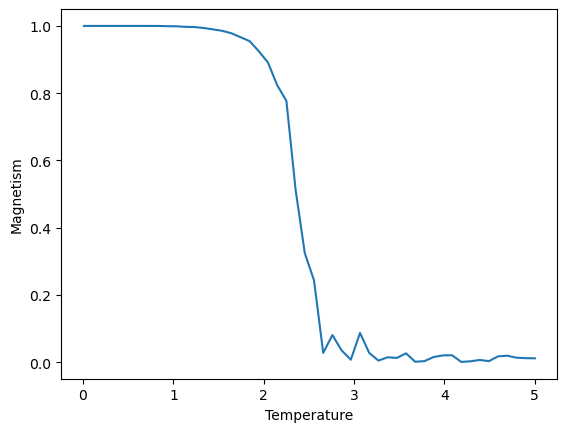

In [4]:
plt.plot(T, M)
plt.xlabel("Temperature")
plt.ylabel("Magnetism")
plt.show()

For this demonstration, we iterate over the array of temperatures `T` one by one. This is not very efficient as the results from each temperature do not affect those of other temperatures, and the MCMC simulation for each temperature should be processed in parallel to speed up processing times. For interested readers, how to implement parallel processing in Python is covered in <a href="https://github.com/natsunoyuki/blog_posts/blob/main/physics/Parallel%20Process%20Monte%20Carlo%20Simulations%20with%20Python.ipynb" target="_blank">another post</a>.

***

## References
* http://www1.spms.ntu.edu.sg/~ydchong/teaching/PH4505-12.htm